In [1]:
import os
import src

In [2]:
sheet = src.Sheet('samples/paraclis.pdf')

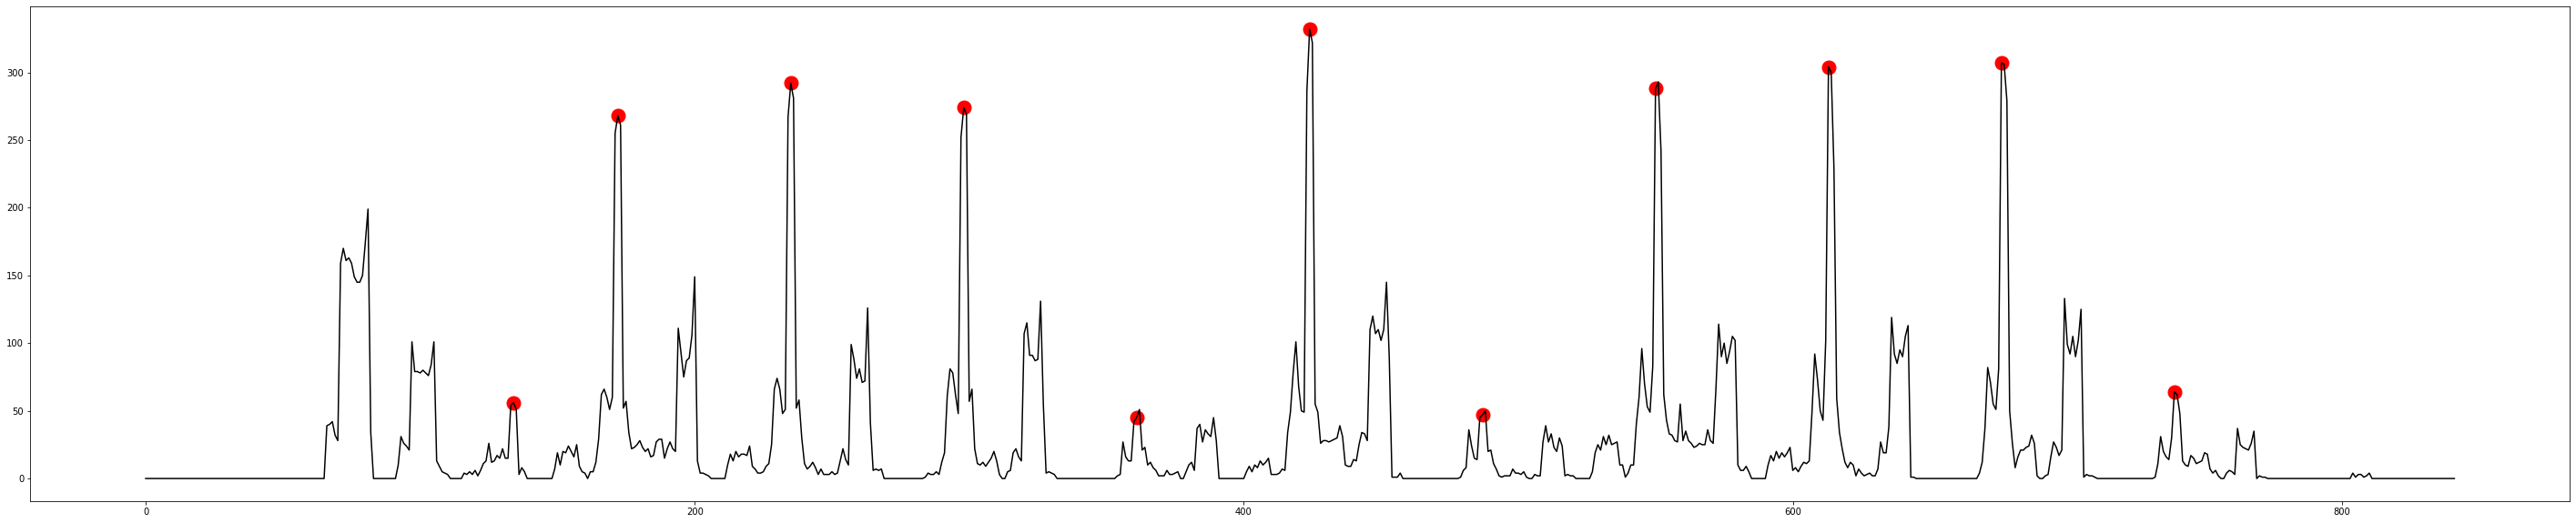

In [3]:
sheet[4].plot_raw_horizontal_projection()

['y = 134', 'y = 172', 'y = 235', 'y = 298', 'y = 361', 'y = 424', 'y = 487', 'y = 550', 'y = 613', 'y = 676', 'y = 739']
b1=y = 134
b2=y = 172
fst_pos=162 mid=153.0
rightmost_max_index=157
max_peaks=[137 150 152 154 157], values=[ 8. 19. 20. 24. 25.]
min_peaks=[136 143 151 153 156 161], values=[ 3.  0. 10. 19. 16.  0.]
! max=[150 152 154 157]
! min=[143 151 153 156 161]
! rhp_max=[19. 20. 24. 25.]
! rhp_min=[ 0. 10. 19. 16.  0.]
max_aux=[], min_aux=[]
snd_pos=139
b1=y = 172
b2=y = 235
fst_pos=212 mid=203.5
rightmost_max_index=200
max_peaks=[175 180 183 187 191 194 200], values=[ 57.  28.  22.  29.  27. 111. 149.]
min_peaks=[174 177 182 184 189 193 196 208], values=[52. 22. 20. 16. 15. 20. 75.  0.]
! max=[180 183 187 191 194 200]
! min=[177 182 184 189 193 196 208]
! rhp_max=[ 28.  22.  29.  27. 111. 149.]
! rhp_min=[22. 20. 16. 15. 20. 75.  0.]
max_aux=[2], min_aux=[3]
snd_pos=206
b1=y = 235
b2=y = 298
fst_pos=284 mid=266.5
rightmost_max_index=263
max_peaks=[238 243 246 250 254 257 26

AttributeError: 'Baseline' object has no attribute 'ub'

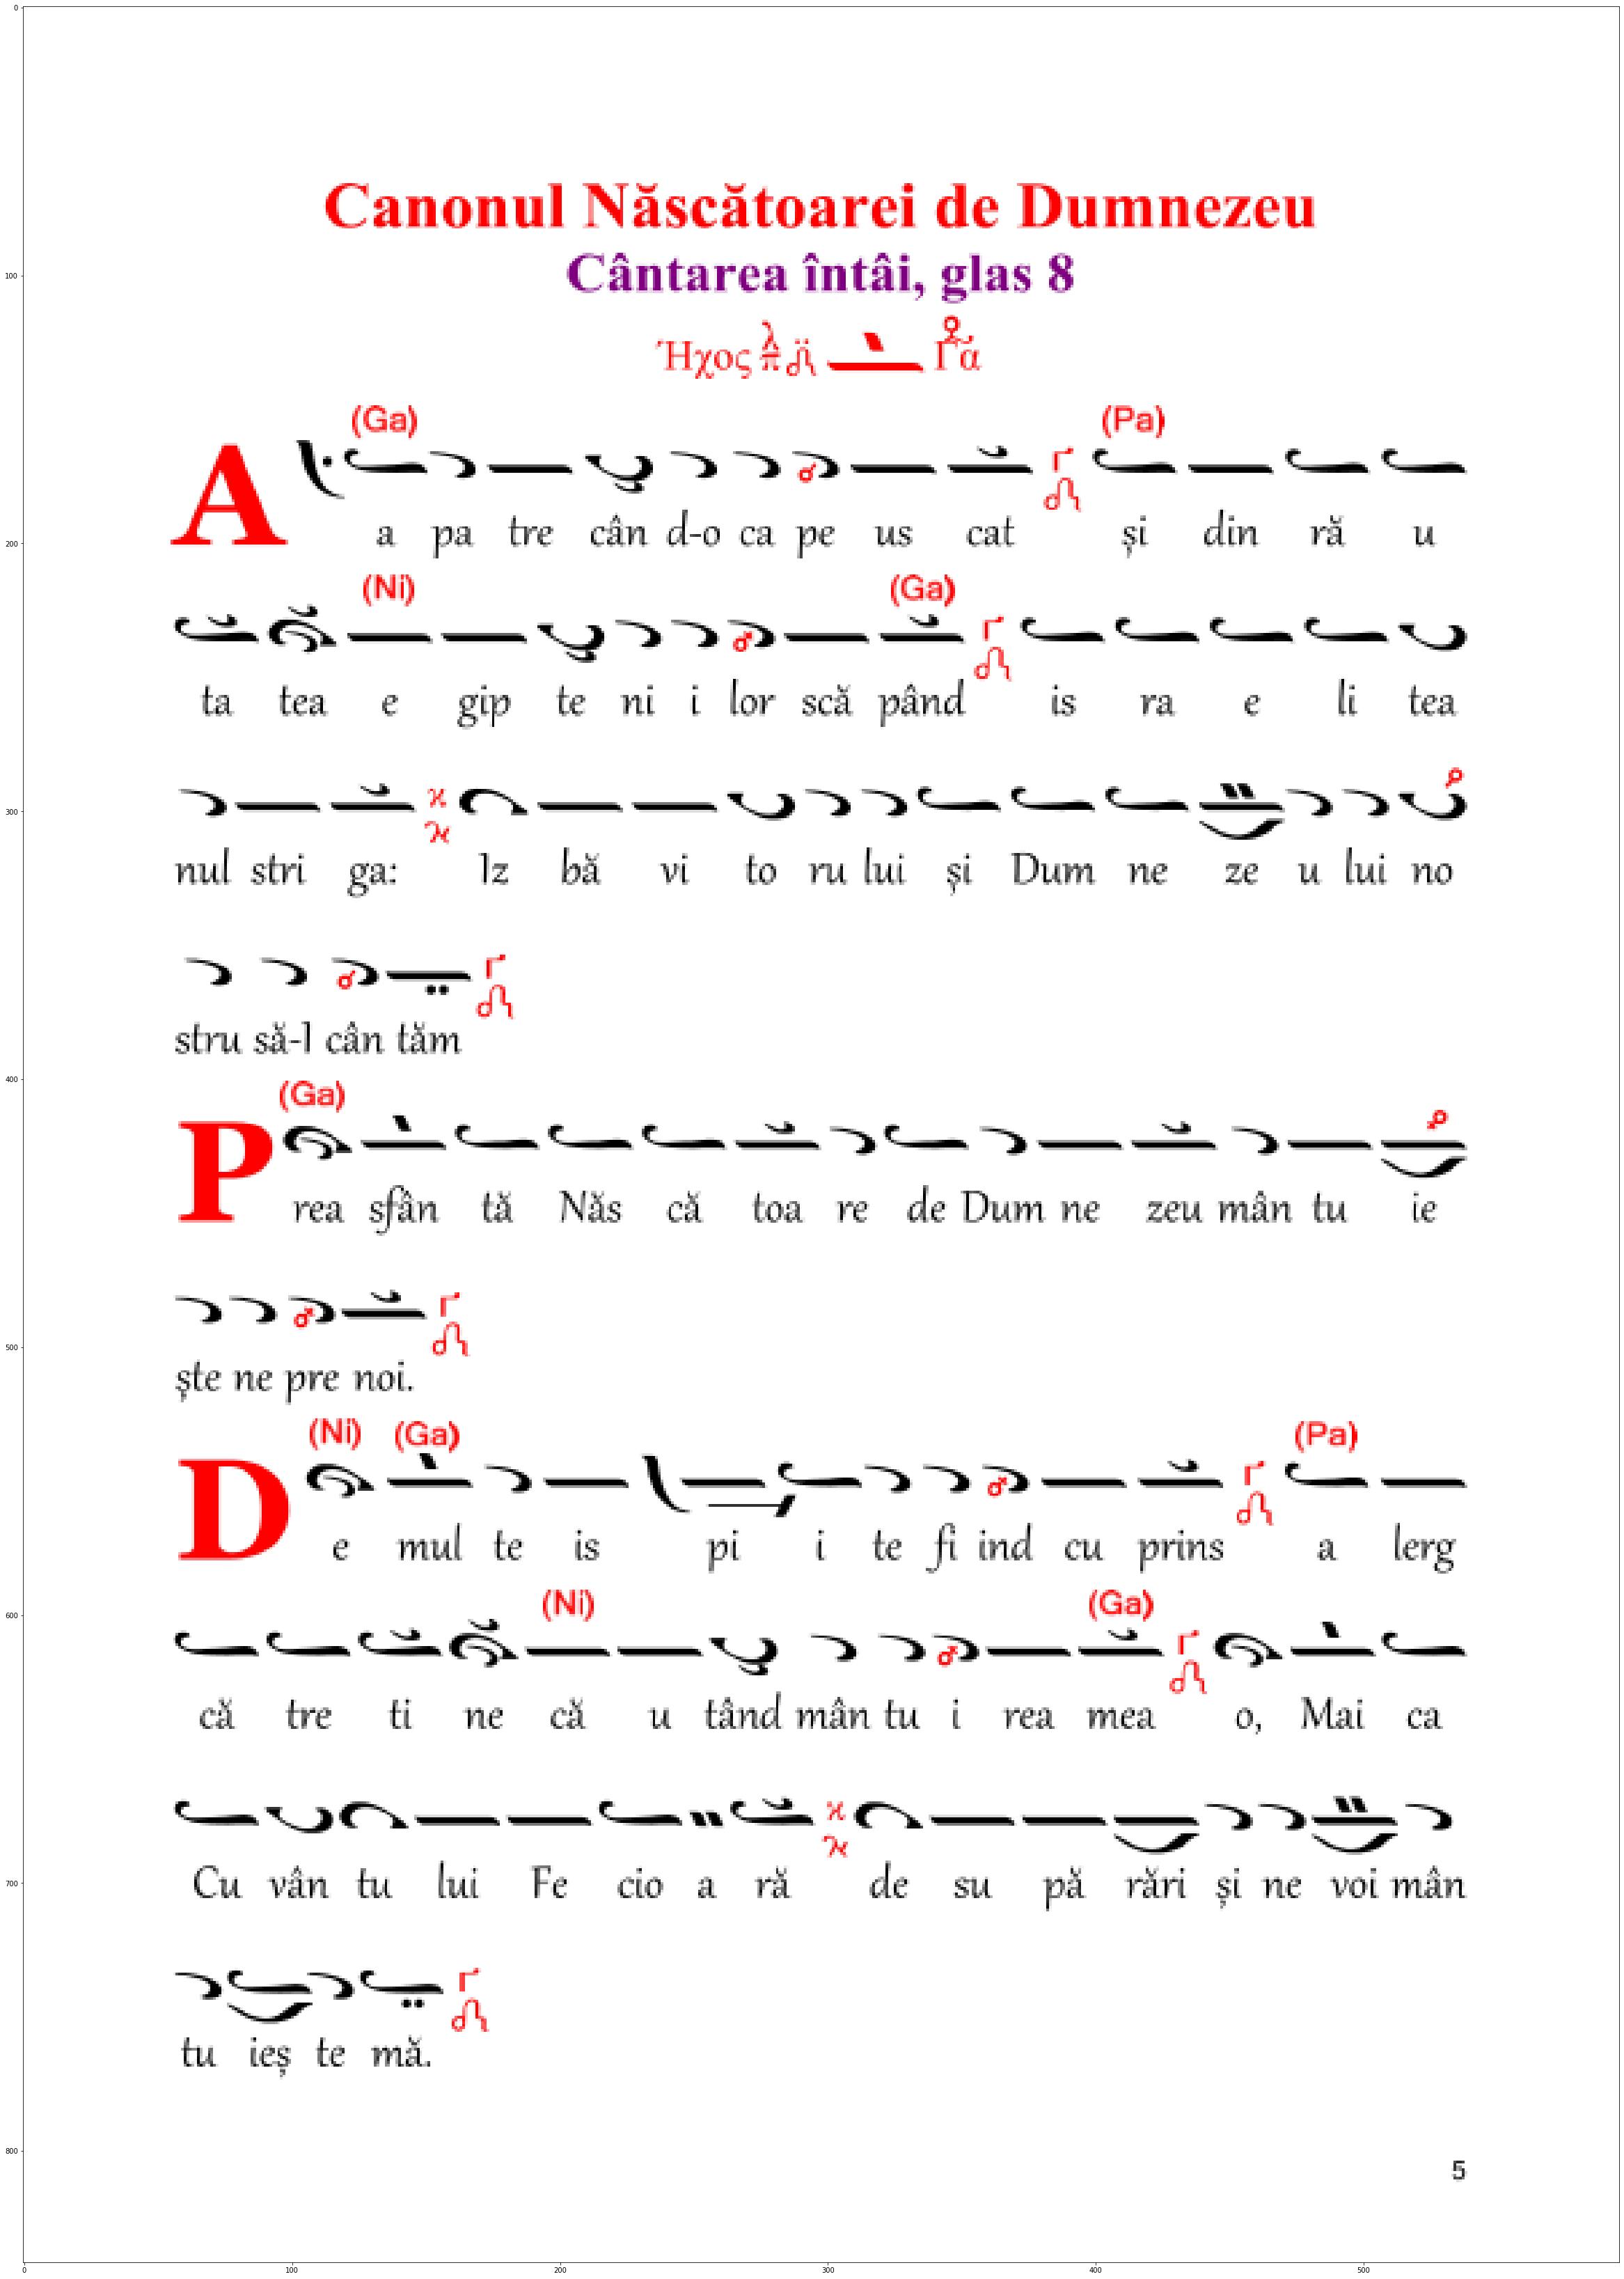

In [4]:
sheet[4].plot_full_baselines()

In [ ]:
print(sheet.oligon_width)
sheet[24].plot_horizontal_projection()

In [ ]:
sheet[3].plot_ccs()